In [4]:
!conda info


     active environment : tf
    active env location : C:\Users\pdine\anaconda3\envs\tf
            shell level : 2
       user config file : C:\Users\pdine\.condarc
 populated config files : 
          conda version : 4.14.0
    conda-build version : 3.21.8
         python version : 3.9.12.final.0
       virtual packages : __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\pdine\anaconda3  (writable)
      conda av data dir : C:\Users\pdine\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/noarch
          package cache : C:\Users\pdine\anaconda3\p

In [5]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import interpolate

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

C:\Users\pdine\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import data

In [6]:
x_list = []
y_list = []

q_list = []
t_0 = -24.0*3600
t_f = 12*3600
t_range = np.linspace(t_0,t_f,100)
#indices = np.random.randint(729, size = 10)
indices = range(729)

for i in indices:
    s_i = np.genfromtxt('../branchruns3/storms/LongIsland_%04d.storm'% i,skip_header = 3)
    f_x = interpolate.interp1d(s_i[:,0],s_i[:,1],fill_value = 'extrapolate')
    f_y = interpolate.interp1d(s_i[:,0],s_i[:,2],fill_value = 'extrapolate')
    x_list.append(TimeSeries.from_values(f_x(t_range)))
    y_list.append(TimeSeries.from_values(f_y(t_range)))
    q_i = np.genfromtxt('../branchruns3/branching_outputs/%04d_output/gauge00001.txt'% i,skip_header=10, usecols = [0,1,5])
    j4s = q_i[:,0] >= 4
    f_q = interpolate.interp1d(q_i[j4s,1],q_i[j4s,2],fill_value = (0,q_i[j4s,2][-1]),bounds_error = False)
    q_list.append(TimeSeries.from_values(f_q(t_range)))
    #ax1.plot(q_i[j4s,1]/3600,q_i[j4s,2])
    #ax1.plot(t_range/3600,f_q(t_range))
    #ax1.set_xlabel("t/h")
    #ax2.plot(t_range/3600, f_y(t_range), '--')
#plt.show()


In [7]:
s_list = []
for i in range(729):
    s_i = np.genfromtxt('../branchruns3/storms/LongIsland_%04d.storm'% i,skip_header = 3)
    f_x = interpolate.interp1d(s_i[:,0],s_i[:,1],fill_value = 'extrapolate')
    f_y = interpolate.interp1d(s_i[:,0],s_i[:,2],fill_value = 'extrapolate')
    s_list.append(TimeSeries.from_values(np.array([f_x(t_range),f_y(t_range)]).transpose()))

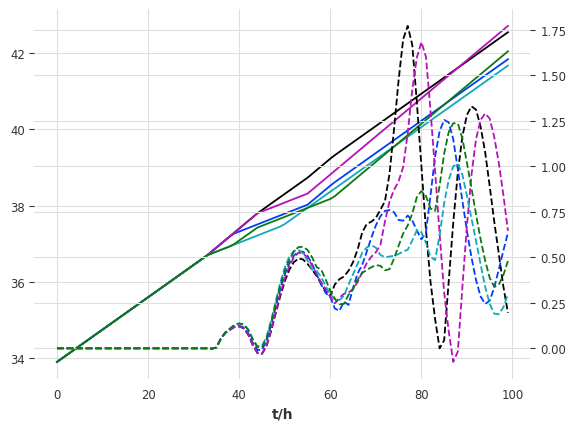

In [8]:
fig,ax1=plt.subplots()
ax2=ax1.twinx() 
indices = np.random.randint(729, size = 5)
for i in indices:
    #ax1.plot(t_range/3600,x_list[i])
    ax1.plot(y_list[i].values())
    ax1.set_xlabel("t/h")
    ax2.plot(q_list[i].values(), '--')
plt.show()

In [29]:
k = 80


In [26]:
shuffler = np.random.permutation(len(q_list))

In [32]:
partition = int(0.8*len(q_list))
train_indices = shuffler[:partition]
test_indices = shuffler[partition:]
q_train = []
s_train = []
q_test = []
s_test = []
for i in train_indices:
    q_train.append(q_list[i])
    s_train.append(s_list[i])
for i in test_indices:
    q_test.append(q_list[i])
    s_test.append(s_list[i])       


In [28]:
print(len(q_list))
print(len(q_train))


729
583


# Model

model.fit(series=[series1, series2, ...],
          past_covariates=[past_cov1, past_cov2, ...],
          future_covariates=[future_cov1, future_cov2, ...])
          
future = model.predict(n=36,
                       series=series_to_forecast,
                       past_covariates=past_covariate_series,
                       future_covariates=future_covariate_series)

In [30]:
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=20,
    output_chunk_length=10,
    n_epochs=40,
    random_state=0,
)

In [33]:
model_cov.fit(
    series=q_train,
    past_covariates=s_train,
#    future_covariates=s_list,
    verbose=True,
)

2022-09-13 14:32:03 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-09-13 14:32:03 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-13 14:32:03 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-13 14:32:03 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-13 14:32:04 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.026     Total estimated model params size (MB)


Epoch 0:   0%|▏                                         | 5/1294 [00:00<00:41, 31.16it/s, loss=0.297, train_loss=0.285]

C:\Users\pdine\anaconda3\envs\tf\lib\site-packages\pytorch_lightning\core\module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)


Epoch 39: 100%|████████████████████████████████████| 1294/1294 [00:29<00:00, 44.42it/s, loss=0.0125, train_loss=0.0115]

2022-09-13 14:53:19 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|████████████████████████████████████| 1294/1294 [00:29<00:00, 44.41it/s, loss=0.0125, train_loss=0.0115]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


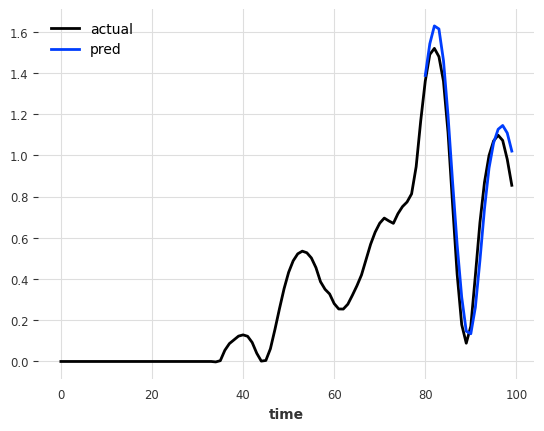

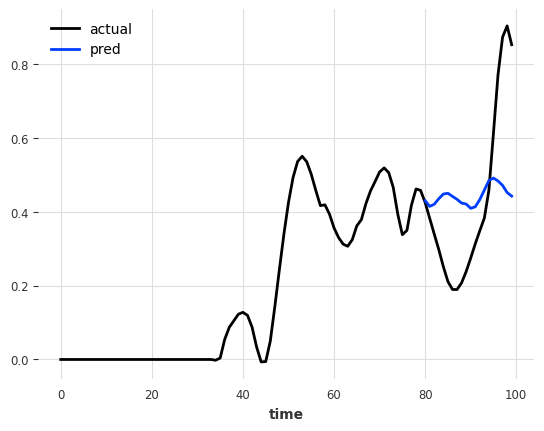

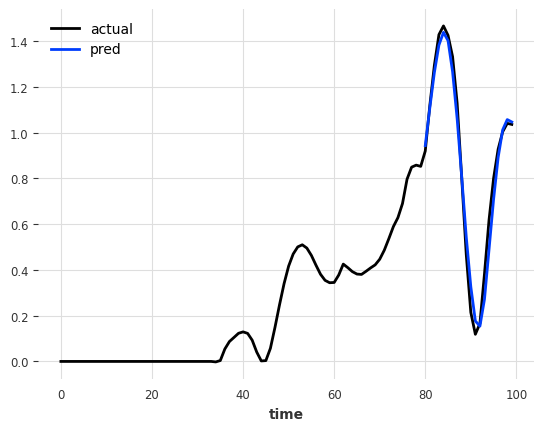

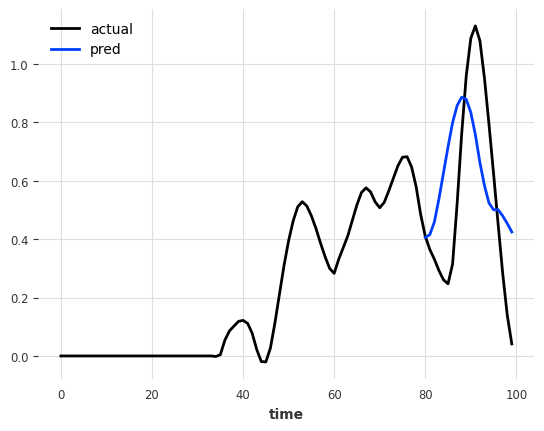

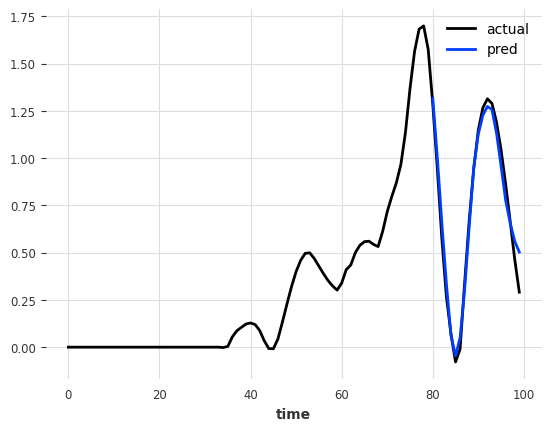

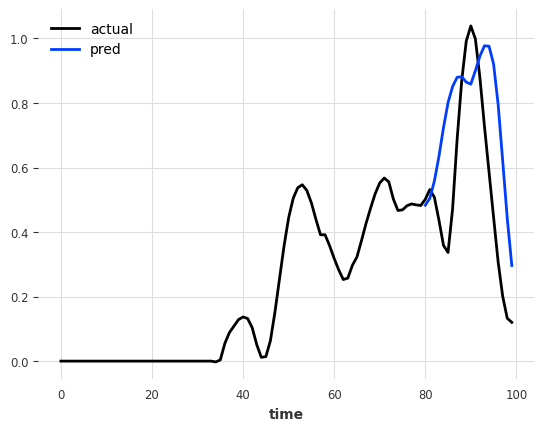

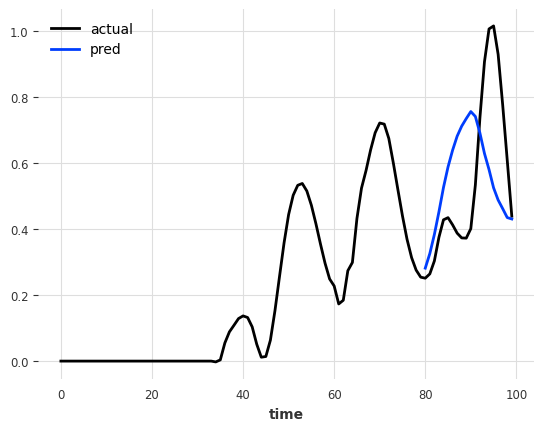

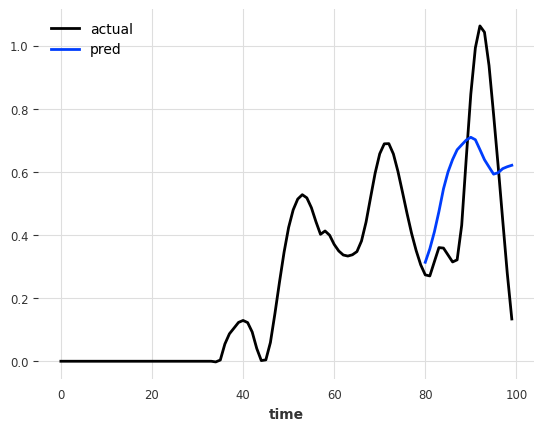

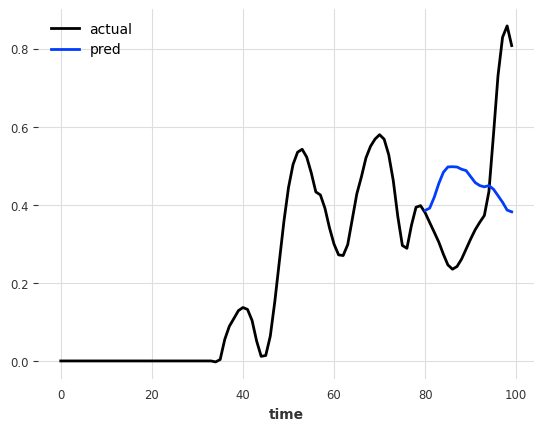

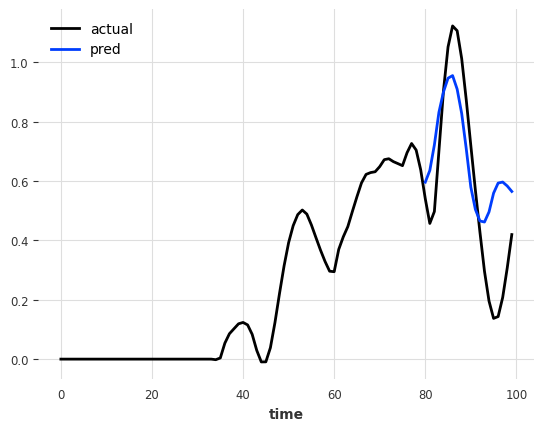

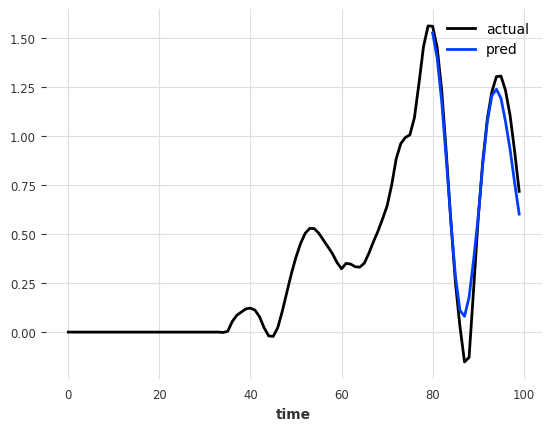

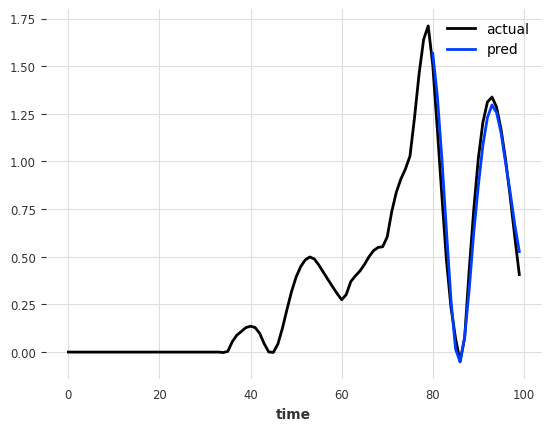

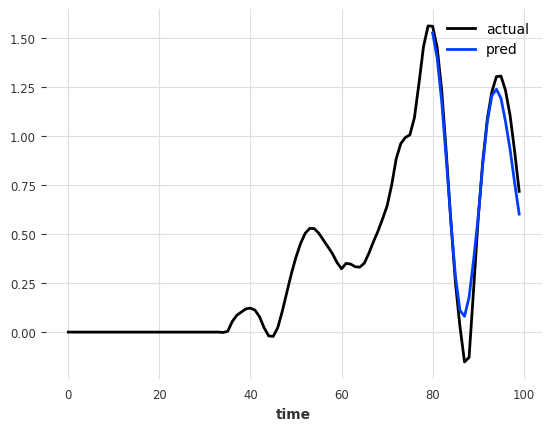

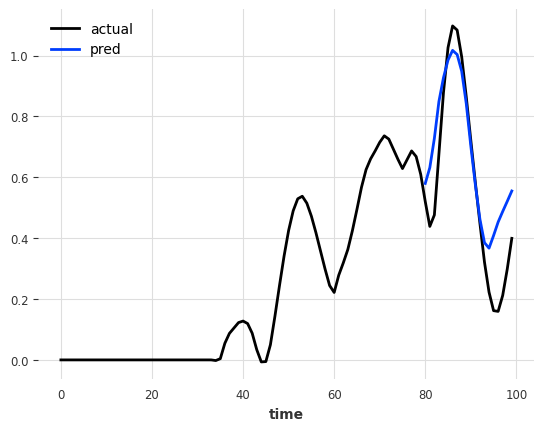

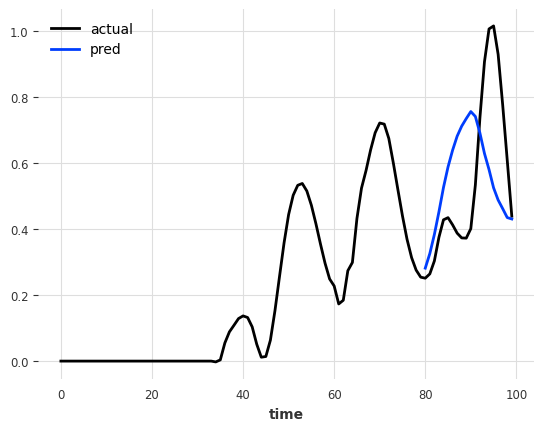

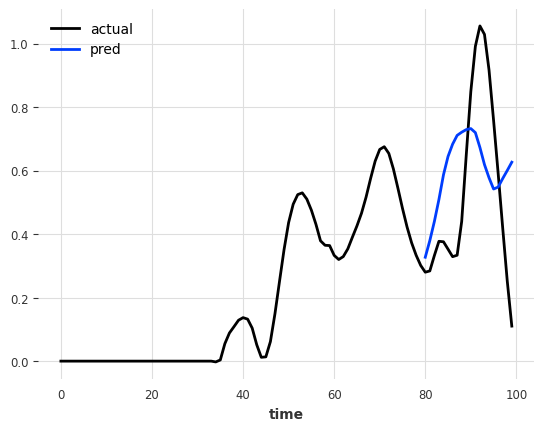

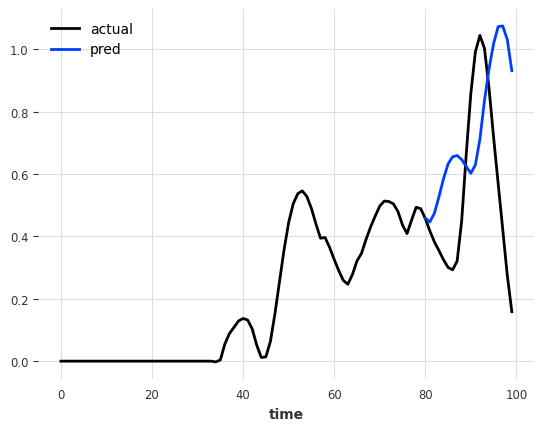

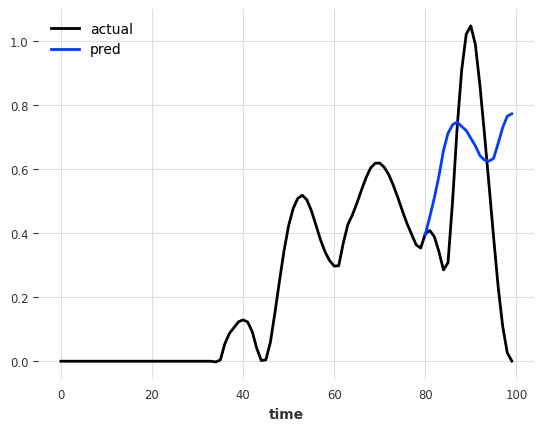

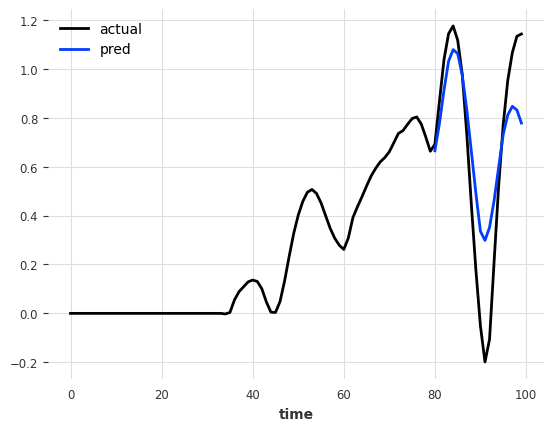

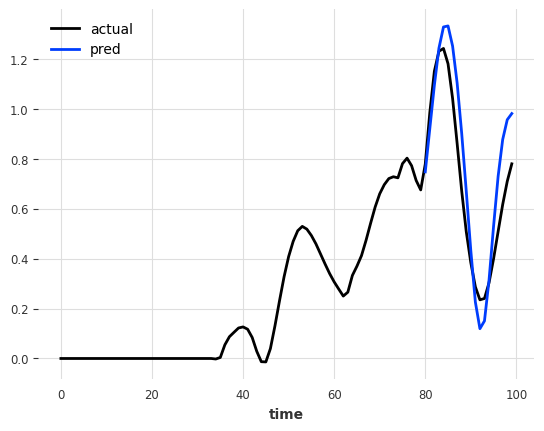

In [37]:
indices = np.random.randint(len(q_test),size = 20)
for i in indices:
    plt.figure()
    future = model_cov.predict(n=20,
                           series=q_test[i][:-20],
                           past_covariates=s_test[i])
    q_test[i].plot(label="actual")
    future.plot(label = "pred")
    plt.legend()

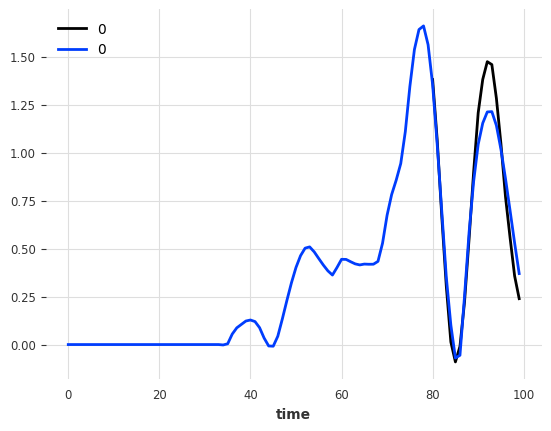

In [42]:
future.plot()
q_list[i].plot()

In [1]:
80/100*36-24

4.800000000000001